In [33]:
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
import gsw
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter as gf

In [4]:
ds = xr.open_dataset('LLC4320_pre_data1.nc')
time_window = 12 # in hours
time_selected = 13
lat_selected = 100
ds = ds.rolling(time=time_window).mean() # running mean
ds = ds.isel(time=time_selected)

In [25]:
# compute absolute salinity and conservative temperature
ds['p'] = ('k', gsw.p_from_z(ds.Z,ds.YC.mean()))
p,XC,YC = xr.broadcast(ds.p,ds.XC,ds.YC)
ds['SA'] = (('k','j','i'), gsw.SA_from_SP(ds.Salt,p,XC,YC))
ds['CT'] = (('k','j','i'), gsw.CT_from_t(ds.SA,ds.Theta,p))

# compute geostrophic streamfunction and geostrophic velocity
p_ref = 500
ds['geo_strf'] = (('k','j','i'), gsw.geo_strf_dyn_height(ds.SA, ds.CT, -ds.Z,p_ref=p_ref))
vel, midlon, midlat = gsw.geostrophic_velocity(
    ds.geo_strf.isel(j=lat_selected),
    ds.XC.isel(j=lat_selected),
    ds.YC.isel(j=lat_selected))

In [26]:
geo_U, midlon1, midlat1 = gsw.geostrophic_velocity(
    ds.geo_strf.isel(i = 100),
    ds.XC.isel(i = 100),
    ds.YC.isel(i= 100))

Text(0.5, 1.0, 'Model')

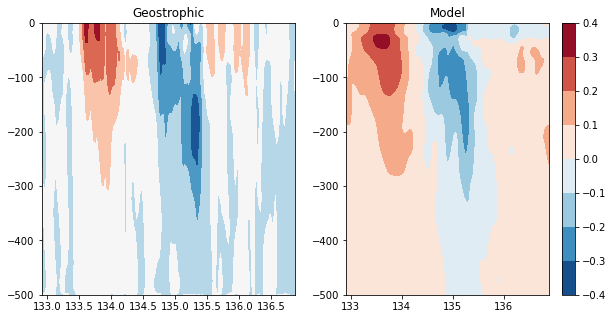

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(midlon,ds.Z,vel, cmap='RdBu_r')
h = ax[1].contourf(ds.XC.isel(j=lat_selected),ds.Z,ds.V.isel(j_g=lat_selected), cmap='RdBu_r')
plt.colorbar(h)
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Geostrophic')
ax[1].set_title('Model')

Text(0.5, 1.0, 'Geostrophic_U')

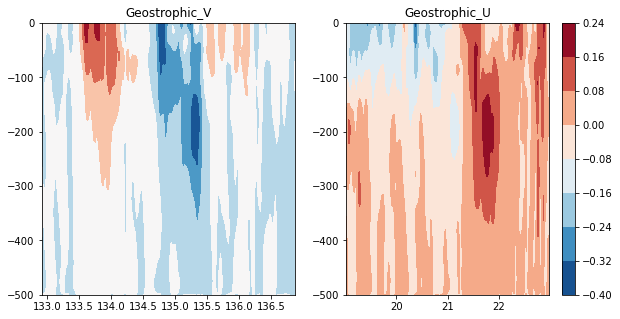

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].contourf(midlon,ds.Z,vel, cmap='RdBu_r')
h = ax[1].contourf(midlat1,ds.Z,geo_U, cmap='RdBu_r')
plt.colorbar(h)
ax[0].set_ylim(-500,0)
ax[1].set_ylim(-500,0)
ax[0].set_title('Geostrophic_V')
ax[1].set_title('Geostrophic_U')

In [14]:
ds = ds.assign_coords(Z=('k',ds.Z))

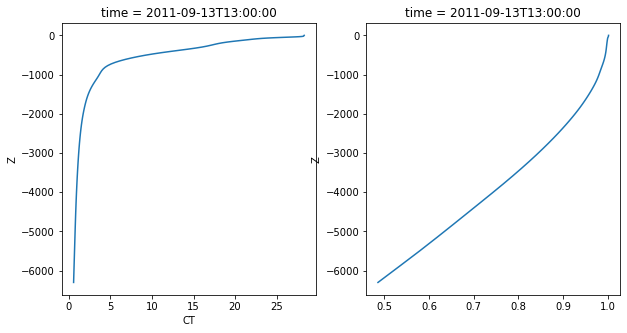

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ds.CT.mean(['i','j']).plot(y = 'Z',ax = ax[0])
#ds.Theta.mean(['i','j']).plot(y = 'Z', ax = ax[1])
(ds.CT/ds.Theta).mean(['i','j']).plot(y = 'Z',ax = ax[1])